# MIMIC II DATA SET

# importing libraries

In [1]:

import os
import numpy as np 
import pandas as pd
import scipy.io
import warnings 
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from scipy import signal
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt




## Where to save the figures

In [2]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = PROJECT_ROOT_DIR
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    plt.savefig(path, format=fig_extension, dpi=resolution,
                bbox_inches="tight", pad_inches=0,)

## read all file from folder data

In [3]:
warnings.filterwarnings('ignore')
dir_data=os.listdir('data')
dir_data

['part_1.mat',
 'part_10.mat',
 'part_11.mat',
 'part_12.mat',
 'part_2.mat',
 'part_3.mat',
 'part_4.mat',
 'part_5.mat',
 'part_6.mat',
 'part_7.mat',
 'part_8.mat',
 'part_9.mat',
 'Samples']

##  understand the data dimensions

In [6]:
test_sample = scipy.io.loadmat(f'data/part_{1}.mat')['p']    
print(f'test_sample Data type: {type(test_sample)}')
print(f'test_sample shape/dimensions: {test_sample.shape}')

test_sample Data type: <class 'numpy.ndarray'>
test_sample shape/dimensions: (1, 1000)


In [7]:
def Load_record(Record_number):
    test_sample = scipy.io.loadmat(f'data/part_{Record_number}.mat')['p']
    return test_sample


## Extracting signal data

In [10]:
ecg = []
ppg = []
bp = []
sbp = [] #Systolic Blood Pressure
dbp = [] #Diastolic Blood Pressue
size = 125 #sample size
parts = [1,2,3]#,4,5,6,7,8,9,10,11,12]

for j in parts:
    test_sample=Load_record(j)
    for i in range(1000):      
        temp_mat = test_sample[0, i]
        temp_length = temp_mat.shape[1]
        for j in range((int)(temp_length/size)):
            temp_ecg = temp_mat[2, j*size:(j+1)*size]
            temp_bp = temp_mat[1, j*size:(j+1)*size]
            temp_ppg = temp_mat[0, j*size:(j+1)*size]

            max_value = max(temp_bp)
            min_value = min(temp_bp)

            sbp.append(max_value)
            dbp.append(min_value)
            ecg.append(temp_ecg)
            ppg.append(temp_ppg)
            bp.append(temp_bp)

## Reshaping the ecg, ppg and bp signal data into column vectors


In [11]:
ppg, ecg, bp = np.array(ppg).reshape(-1,1), np.array(ecg).reshape(-1,1), np.array(bp).reshape(-1,1)
sbp, dbp = np.array(sbp).reshape(-1,1), np.array(dbp).reshape(-1,1)
print(f'PPG_shape: {ppg.shape}\n ECG_shape: {ecg.shape}\n BP_shape: {bp.shape}')
print(f'Systolic-BP_shape: {sbp.shape},\n Diastolic-BP_shape: {dbp.shape}')

PPG_shape: (82774000, 1)
 ECG_shape: (82774000, 1)
 BP_shape: (82774000, 1)
Systolic-BP_shape: (662192, 1),
 Diastolic-BP_shape: (662192, 1)


## grap visualization of ECG,PPG,BP

Saving figure graph_of_signals


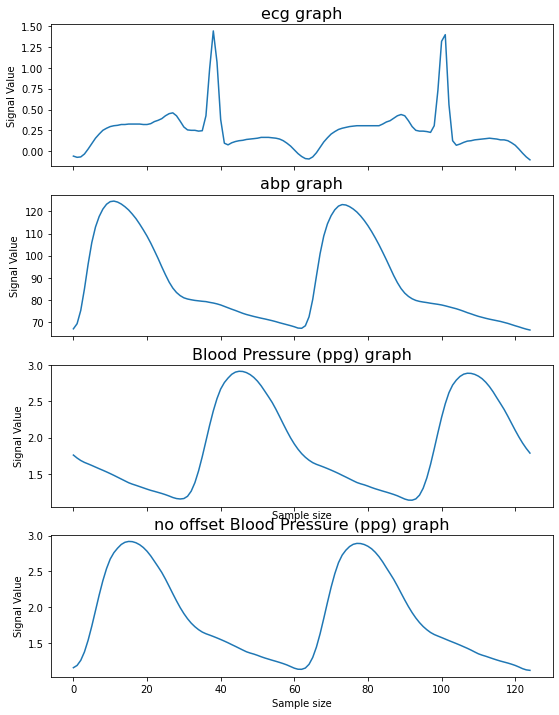

In [12]:
fig, ax = plt.subplots(4,1, figsize=(9,12), sharex=True)

ax[0].set_title('ecg graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(ecg[:125])

ax[1].set_title('abp graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(bp[:125])

ax[2].set_title('Blood Pressure (ppg) graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(ppg[:125])

ax[3].set_title('no offset Blood Pressure (ppg) graph', fontsize=16)
ax[3].set_ylabel('Signal Value')
ax[3].set_xlabel('Sample size')
ax[3].plot(ppg[30:155])
save_fig('graph_of_signals')

Saving figure graph_of_SBP_DBP


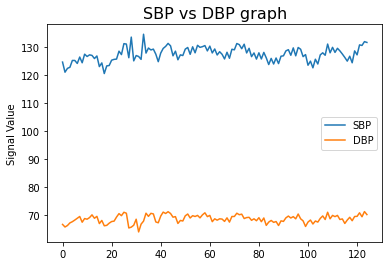

In [13]:
plt.title('SBP vs DBP graph', fontsize=16)
plt.ylabel('Signal Value')
plt.plot(sbp[:125])
plt.plot(dbp[:125])
plt.legend(['SBP', 'DBP'])
save_fig('graph_of_SBP_DBP')

In [14]:
x=len(ppg)/len(sbp)
x

125.0

## peak detection and distance calculation

## 1st way

[62, 62]


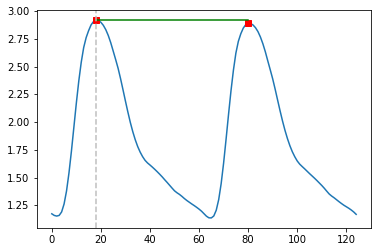

In [110]:
from detecta import detect_peaks
# detection of valleys instead of peaks
single_segment_ppg = ppg[27:152]
data=single_segment_ppg.reshape(single_segment_ppg.size)
peak_n =detect_peaks(data, mph=0, mpd=10, show=False)
list_peaks=peak_n.tolist()
distance=[abs(v - (list_peaks+[list_peaks[0]])[i+1]) for i, v in enumerate(list_peaks)]
print(distance)
plot(data)
plot(m, y, 'rs')
for i in range(len(distances)):
    plot([m[i], m[i] + distances[i]], 2*[y[i]], color = 'g')
    axvline(m[i], linestyle='--', color='0.75')

## 2nd way

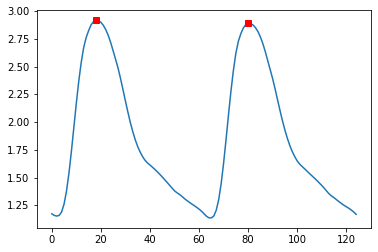

In [94]:
import numpy as np
from scipy.signal import argrelextrema
from matplotlib.pyplot import *

m = argrelextrema(data, np.greater)[0] #array of indexes of the locals maxima
y = [data[i] for i in m] #array of max values

plot(data)
plot(m, y, 'rs')
show()

In [96]:
distances = [np.linalg.norm(np.array([m[i], y[i-1]]) - np.array([m[i-1], y[i-1]])) for i in np.arange(1, len(m))]
distances2 = [m[i] - m[i-1] for i in np.arange(1, len(m))]
distances3 = np.diff(m)
print(distances)
print(distances2)
print(distances3)

[62.0]
[62]
[62]


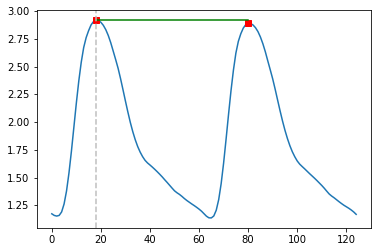

In [98]:
plot(data)
plot(m, y, 'rs')
for i in range(len(distances)):
    plot([m[i], m[i] + distances[i]], 2*[y[i]], color = 'g')
    axvline(m[i], linestyle='--', color='0.75')

## 3rd way

Saving figure graph_of_Features


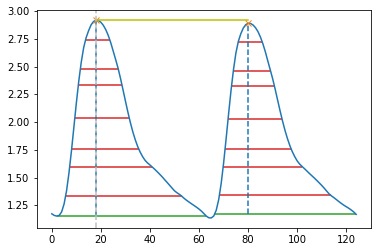

In [150]:
from scipy.signal import chirp, find_peaks, peak_widths
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences

peaks, _ = find_peaks(data)
prominences = peak_prominences(data, peaks)[0]
contour_heights = data[peaks] - prominences
list_peaks=peak_n.tolist()
distance=[abs(v - (list_peaks+[list_peaks[0]])[i+1]) for i, v in enumerate(list_peaks)]

results_full = peak_widths(data, peaks, rel_height=1)
results_half_90 = peak_widths(data, peaks, rel_height=0.9)
results_half_66 = peak_widths(data, peaks, rel_height=0.66)
results_half_75 = peak_widths(data, peaks, rel_height=.75)
results_half_50 = peak_widths(data, peaks, rel_height=0.5)
results_half_33 = peak_widths(data, peaks, rel_height=0.33)
results_half_25 = peak_widths(data, peaks, rel_height=0.25)
results_half_10 = peak_widths(data, peaks, rel_height=0.1)


plt.plot(data)
plt.plot(peaks, data[peaks], "x")
plt.hlines(*results_full[1:], color="C2")
plt.hlines(*results_half_90[1:], color="C3")
plt.hlines(*results_half_66[1:], color="C3")
plt.hlines(*results_half_75[1:], color="C3")
plt.hlines(*results_half_50[1:], color="C3")
plt.hlines(*results_half_33[1:], color="C3")
plt.hlines(*results_half_25[1:], color="C3")
plt.hlines(*results_half_10[1:], color="C3")
plt.vlines(x=peaks,linestyle='--', ymin=contour_heights, ymax=data[peaks])

for i in range(len(distances)):
    plot([m[i], m[i] + distances[i]], 2*[y[i]], color = 'y')
    axvline(m[i], linestyle='--', color='0.75')
    
save_fig('graph_of_Features')
plt.show()


[1.15249267 1.16813294]


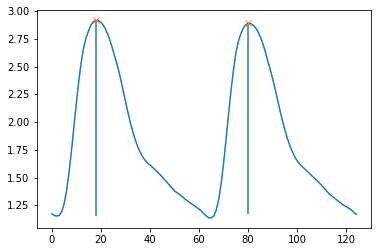

In [213]:
from scipy.signal import find_peaks, peak_prominences

peaks, _ = find_peaks(data)
prominences = peak_prominences(data, peaks)[0]
contour_heights = data[peaks] - prominences
print(contour_heights)
plt.plot(data)
plt.plot(peaks, data[peaks], "x")
plt.vlines(x=peaks, ymin=contour_heights, ymax=data[peaks])
plt.show()

## single beat

In [182]:
from scipy.signal import find_peaks, peak_prominences
single_segment_ppg = ppg[27:90]
data=single_segment_ppg.reshape(single_segment_ppg.size)


Peaks [18]
heights [1.17399804]
all peaks [18, 80]
distance [62, 62]
Saving figure graph_of_Features


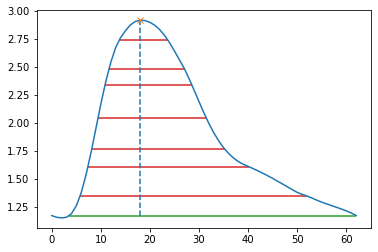

In [184]:
peaks, _ = find_peaks(data)
prominences = peak_prominences(data, peaks)[0]
contour_heights = data[peaks] - prominences
list_peaks=peak_n.tolist()
distance=[abs(v - (list_peaks+[list_peaks[0]])[i+1]) for i, v in enumerate(list_peaks)]

print("Peaks",peaks)
print("heights",contour_heights)
print("all peaks",list_peaks)
print("distance",distance)

results_full = peak_widths(data, peaks, rel_height=1)
results_half_90 = peak_widths(data, peaks, rel_height=0.9)
results_half_66 = peak_widths(data, peaks, rel_height=0.66)
results_half_75 = peak_widths(data, peaks, rel_height=.75)
results_half_50 = peak_widths(data, peaks, rel_height=0.5)
results_half_33 = peak_widths(data, peaks, rel_height=0.33)
results_half_25 = peak_widths(data, peaks, rel_height=0.25)
results_half_10 = peak_widths(data, peaks, rel_height=0.1)


plt.plot(data)
plt.plot(peaks, data[peaks], "x")
plt.hlines(*results_full[1:], color="C2")
plt.hlines(*results_half_90[1:], color="C3")
plt.hlines(*results_half_66[1:], color="C3")
plt.hlines(*results_half_75[1:], color="C3")
plt.hlines(*results_half_50[1:], color="C3")
plt.hlines(*results_half_33[1:], color="C3")
plt.hlines(*results_half_25[1:], color="C3")
plt.hlines(*results_half_10[1:], color="C3")
plt.vlines(x=peaks,linestyle='--', ymin=contour_heights, ymax=data[peaks])
   
save_fig('graph_of_Features')
plt.show()


## statistical feature extraction

In [91]:
def calculate_statistics(list_values):
    Vmax = list_values.max()
    Vmin = list_values.min()
    m=[Vmin,Vmax]
    distances = np.diff(m)
    n5 = np.nanpercentile(list_values, 5)
    n10 = np.nanpercentile(list_values, 10)
    n25 = np.nanpercentile(list_values, 25)
    n33 = np.nanpercentile(list_values, 33)
    n50 = np.nanpercentile(list_values, 50)
    n66 = np.nanpercentile(list_values, 66)
    n75 = np.nanpercentile(list_values, 75)
    n90 = np.nanpercentile(list_values, 90)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    sum_ = np.nansum(list_values)
    return [distances,Vmax,Vmin,n5,n10, n25,n33,n50,n66, n75,n90, n95, median, mean, std, var, rms,sum_]


In [92]:
def get_features(list_values):
    #entropy = calculate_entropy(list_values)
    #crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return  statistics
Statistical_features=get_features(single_segment_ppg)
Statistical_features

[array([1.78201369]),
 2.9178885630498534,
 1.1358748778103618,
 1.1603128054740959,
 1.2,
 1.3304007820136852,
 1.4262756598240471,
 1.6304985337243403,
 2.08633431085044,
 2.4682306940371457,
 2.829325513196481,
 2.87741935483871,
 1.6304985337243403,
 1.8587135874877811,
 0.6058639802631456,
 0.36707116258030126,
 1.8587135874877811,
 232.33919843597263]

In [211]:
import numpy as np
from scipy.signal import argrelmax, argrelmin
#from params import PPG_SAMPLE_RATE

single_segment_ppg = ppg[27:152]
data=single_segment_ppg.reshape(single_segment_ppg.size)

def extract_ppg45(single_waveform, sample_rate=125):
    def __next_pow2(x):
        return 1<<(x-1).bit_length()
    features = []
    maxima_index = argrelmax(np.array(single_waveform))[0]
    minima_index = argrelmin(np.array(single_waveform))[0]
    derivative_1 = np.diff(single_waveform, n=1) * float(sample_rate)
    derivative_1_maxima_index = argrelmax(np.array(derivative_1))[0]
    derivative_1_minima_index = argrelmin(np.array(derivative_1))[0]
    derivative_2 = np.diff(single_waveform, n=2) * float(sample_rate)
    derivative_2_maxima_index = argrelmax(np.array(derivative_2))[0]
    derivative_2_minima_index = argrelmin(np.array(derivative_2))[0]
    sp_mag = np.abs(np.fft.fft(single_waveform, n=__next_pow2(len(single_waveform))*16))
    freqs = np.fft.fftfreq(len(sp_mag))
    sp_mag_maxima_index = argrelmax(sp_mag)[0]
    # x
    x = single_waveform[maxima_index[0]]
    features.append(x)
    # y
    y = single_waveform[maxima_index[1]]
    features.append(y)
    # z
    z = single_waveform[minima_index[0]]
    features.append(z)
    # t_pi
    t_pi = float(len(single_waveform)) / float(sample_rate)
    features.append(t_pi)
    # y/x
    features.append(y / x)
    # (x-y)/x
    features.append((x - y) / x)
    # z/x
    features.append(z / x)
    # (y-z)/x
    features.append((y - z) / x)
    # t_1
    t_1 = float(maxima_index[0] + 1) / float(sample_rate)
    features.append(t_1)
    # t_2
    t_2 = float(minima_index[0] + 1) / float(sample_rate)
    features.append(t_2)
    # t_3
    t_3 = float(maxima_index[1] + 1) / float(sample_rate)
    features.append(t_3)
    # delta_t
    delta_t = t_3 - t_2
    features.append(delta_t)
    # width
    single_waveform_halfmax = max(single_waveform) / 2
    plt.plot(single_waveform)
    plt.show()
    width = 0
    for value in single_waveform[maxima_index[0]::-1]:
        if value >= single_waveform_halfmax:
            width += 1
        else:
            break
            
    print(width)
    
    for value in single_waveform[maxima_index[0]+1:]:
        if value >= single_waveform_halfmax:
            width += 1
        else:
            break
            
    print(width)
    
    features.append(float(width) / float(sample_rate))
    # A_2/A_1
    features.append(sum(single_waveform[:maxima_index[0]]) / sum(single_waveform[maxima_index[0]:]))
    # t_1/x
    features.append(t_1 / x)
    # y/(t_pi-t_3)
    features.append(y / (t_pi - t_3))
    # t_1/t_pi
    features.append(t_1 / t_pi)
    # t_2/t_pi
    features.append(t_2 / t_pi)
    # t_3/t_pi
    features.append(t_3 / t_pi)
    # delta_t/t_pi
    features.append(delta_t / t_pi)
    # t_a1
    t_a1 = float(derivative_1_maxima_index[0]) / float(sample_rate)
    features.append(t_a1)
    # t_b1
    t_b1 = float(derivative_1_minima_index[0]) / float(sample_rate)
    features.append(t_b1)
    # t_e1
    t_e1 = float(derivative_1_maxima_index[1]) / float(sample_rate)
    features.append(t_e1)
    # t_f1
    t_f1 = float(derivative_1_minima_index[1]) / float(sample_rate)
    features.append(t_f1)
    # b_2/a_2
    a_2 = derivative_2[derivative_2_maxima_index[0]]
    b_2 = derivative_2[derivative_2_minima_index[0]]
    features.append(b_2 / a_2)
    # e_2/a_2
    e_2 = derivative_2[derivative_2_maxima_index[1]]
    features.append(e_2 / a_2)
    # (b_2+e_2)/a_2
    features.append((b_2 + e_2) / a_2)
    # t_a2
    t_a2 = float(derivative_2_maxima_index[0]) / float(sample_rate)
    features.append(t_a2)
    # t_b2
    t_b2 = float(derivative_2_minima_index[0]) / float(sample_rate)
    features.append(t_b2)
    # t_a1/t_pi
    features.append(t_a1 / t_pi)
    # t_b1/t_pi
    features.append(t_b1 / t_pi)
    # t_e1/t_pi
    features.append(t_e1 / t_pi)
    # t_f1/t_pi
    features.append(t_f1 / t_pi)
    # t_a2/t_pi
    features.append(t_a2 / t_pi)
    # t_b2/t_pi
    features.append(t_b2 / t_pi)
    # (t_a1-t_a2)/t_pi
    features.append((t_a1 - t_a2) / t_pi)
    # (t_b1-t_b2)/t_pi
    features.append((t_b1 - t_b2) / t_pi)
    # (t_e1-t_2)/t_pi
    features.append((t_e1 - t_2) / t_pi)
    # (t_f1-t_3)/t_pi
    features.append((t_f1 - t_3) / t_pi)
    # f_base
    f_base = freqs[sp_mag_maxima_index[0]] * sample_rate
    features.append(f_base)
    # sp_mag_base
    sp_mag_base = sp_mag[sp_mag_maxima_index[0]] / len(single_waveform)
    features.append(sp_mag_base)
    # f_2
    f_2 = freqs[sp_mag_maxima_index[1]] * sample_rate
    features.append(f_2)
    # sp_mag_2
    sp_mag_2 = sp_mag[sp_mag_maxima_index[1]] / len(single_waveform)
    features.append(sp_mag_2)
    # f_3
    f_3 = freqs[sp_mag_maxima_index[2]] * sample_rate
    features.append(f_3)
    # sp_mag_3
    sp_mag_3 = sp_mag[sp_mag_maxima_index[2]] / len(single_waveform)
    features.append(sp_mag_3)
    return features


def extract_svri(single_waveform):
    def __scale(data):
        data_max = max(data)
        data_min = min(data)
        return [(x - data_min) / (data_max - data_min) for x in data]
    max_index = np.argmax(single_waveform)
    single_waveform_scaled = __scale(single_waveform)
    return np.mean(single_waveform_scaled[max_index:]) / np.mean(single_waveform_scaled[:max_index])

In [238]:
dd=[1.61974585, 1.59335288, 1.57282502, 1.55816227, 1.54447703,
       1.52883675, 1.51319648, 1.49657869, 1.47800587, 1.45845552,
       1.43890518, 1.4173998 , 1.39589443, 1.37634409, 1.35777126,
       1.34506354, 1.33431085, 1.32160313, 1.30889541, 1.2971652 ,
       1.28641251, 1.27565982, 1.2629521 , 1.24731183, 1.22776149,
       1.20527859, 1.18475073, 1.17497556, 1.18377322, 1.2170088 ,
       1.28934506, 1.40860215, 1.57282502, 1.771261  , 1.98729228,
       2.20039101, 2.39589443, 2.5601173 , 2.68817204, 2.77908113,
       2.83382209, 2.86217009, 2.87585533, 2.87585533, 2.86314761,
       2.83968719, 2.8054741 , 2.76050831, 2.71652004, 2.66568915,
       2.5943304 , 2.51026393, 2.41642229, 2.32746823, 2.24340176,
       2.15347019, 2.06353861, 1.97947214, 1.90518084, 1.84164223,
       1.78787879, 1.74389052, 1.7086999 , 1.67839687, 1.65200391,
       1.63147605, 1.61388074, 1.59335288, 1.57086999, 1.54643206,
       1.52101662, 1.49462366, 1.46823069, 1.44086022, 1.41251222,
       1.38514174, 1.3597263 , 1.33626588, 1.31964809, 1.30694037,
       1.29227761, 1.27663734, 1.26197458, 1.24828935, 1.23362659,
       1.21603128, 1.19550342, 1.17302053, 1.1544477 , 1.14956012,
       1.16324536, 1.20527859, 1.2913001 , 1.42717498, 1.61094819,
       1.82991202, 2.06549365, 2.29814272, 2.5083089 , 2.68426197,
       2.8230694 , 2.92375367, 2.99022483, 3.02541544, 3.03910068,
       3.04105572, 3.03128055, 3.00977517, 2.97653959, 2.93059629,
       2.87194526, 2.80058651, 2.71749756, 2.62365591, 2.52199413,
       2.42619746, 2.33431085, 2.23460411, 2.13587488, 2.04203324,
       1.95698925, 1.88367546, 1.81915934, 1.76539589, 1.72140762]
x =extract_ppg45(dd) 
x

IndexError: index 1 is out of bounds for axis 0 with size 1

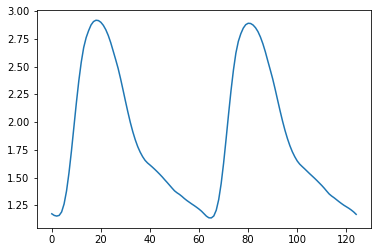

In [233]:
plt.plot(ppg[27:152])

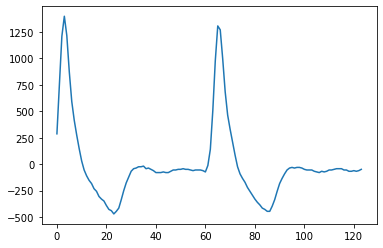

(array([  3,  35,  37,  43,  49,  51,  53,  65,  95, 107, 114, 120],
      dtype=int64),)


In [237]:
derivative_1 = np.diff(data, n=1) * float(125)
derivative_2 = np.diff(data, n=2) * float(125)
derivative_9 = np.diff(data, n=9) * float(125)
plt.plot(derivative_1)
#plt.plot(derivative_2)
#plt.plot(derivative_9)
plt.show()
derivative_1_maxima_index = argrelmax(np.array(derivative_1))
print(derivative_1_maxima_index)

In [189]:
y =extract_svri(data) 
y

0.8887722773409433

In [ ]:
headings=[]

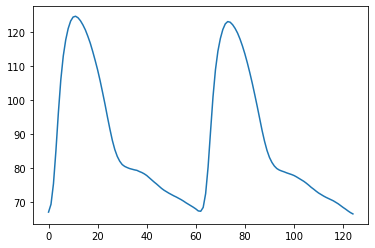

(124.6013099988766, 66.52567001900036)

In [217]:
single_segment_ppg = bp[0:125]
data=single_segment_ppg.reshape(single_segment_ppg.size)
plt.plot(data)
plt.show()
max_value = max(data)
min_value = min(data)
max_value,min_value